# Projeto

Neste projeto, vamos usar classificadores para identificar *quais são os fatores de risco para o acidente vascular cerebral (AVC)*. Um AVC (*stroke*) é um dano cerebral causado pela interrupção de seu fluxo sanguíneo. Ter um AVC é um problema sério porque pode levar a sequelas, então é melhor preveni-lo do que tentar lidar com suas consequências.

Temos à nossa disposição um conjunto de dados para [predição de AVCs](https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset). O que faremos é:

1. Treinar um classificador para predizer se houve ou não houve AVCs
1. Verificar a acurácia do classificador
1. Identificar quais são os fatores que mais provavelmente estão ligados a ter AVCs

## Teoria

### Separando linhas de dados em treino e teste

O que faremos será avaliar um classificador. Lembre-se que para fazer o classificador tivemos que usar uma base de dados pré-classificada. Porém, o que gostaríamos de saber é se, ao ser colocado em produção, o classificador terá um bom desempenho.

Para isso, vamos partir de uma premissa (vou chamar de *premissa número 1* mas esse não é um nome oficial) que é muito importante: a de que nossa base de dados é composta de elementos amostrados aleatoriamente do conjunto total de dados. Nessas condições, a distribuição dos dados na nossa base de dados é a mesma distribuição dos dados que encontraremos no mundo real.

Claro que gostaríamos de saber como nosso classificador se comporta no mundo real, e não na amostra dele que compõe nossa base de dados! Então, precisamos ao menos de ter alguns dados que seguem a mesma distribuição dos dados do mundo real, e que serão usados nas mesmas condições que os dados do mundo real.

Por isso, dividimos nosso conjunto de dados em dois conjuntos: treino e teste. O conjunto de treino é o que será usado para treinar (`fit`) os nossos classificadores. O conjunto de teste será usado para testar (`score`) os classificadores. O conjunto de teste existe para simular uma situação de produção (como se o classificador estivesse operando), então ele não pode ser usado em hipótese alguma para nenhum tipo de ajuste de parâmetros. Ao mesmo tempo, o conjunto de treino é aquele que foi usado para "ensinar" rótulos corretos aos classificadores, então o desempenho dos classificadores no conjunto de treino não é representativo de seu desempenho em produção.

Para dividir os conjuntos de treino e teste, você pode usar a função `train_test_split` do scikit-learn:

    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.5)

### Analisando os dados

Antes de começar qualquer coisa, vamos (como sempre) olhar para os dados que temos. Na nossa tabela, temos uma coluna com a identificação do paciente - essa é uma ID única, anônima, que permite referenciar ao paciente. Também, temos várias colunas com características do paciente: idade, sexo, se fuma, etc. Por fim, temos uma coluna com o *outcome*, que é a coluna `stroke`. Para usar corretamente os classificadores do scikit-learn, você deve separar suas tabelas entre as que têm dados de "entrada" (as features) das que têm dados de "saída" (os *outcomes*).

Outra coisa importante é que os dados deste dataset podem ser categóricos, e nossos sistemas não lidam bem com eles. Por isso, precisamos convertê-los para dados numéricos, por exemplo usando one-hot encoding. Pandas implementa a conversão para one-hot encoding usando `pd.get_dummies(df)`.

In [31]:
import pandas as pd

In [32]:
df = pd.read_csv('data.csv')
df

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


In [33]:
df = df.dropna()

In [34]:
df_clean = pd.get_dummies(df).astype(float)
df_clean = df_clean.drop(columns=['id','age','avg_glucose_level', 'bmi'])
df_clean

,hypertension,heart_disease,stroke,gender_Female,gender_Male,gender_Other,ever_married_No,ever_married_Yes,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
5,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5104,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0
5106,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
5107,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
5108,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


Linear Classification Model

In [35]:
import numpy as np

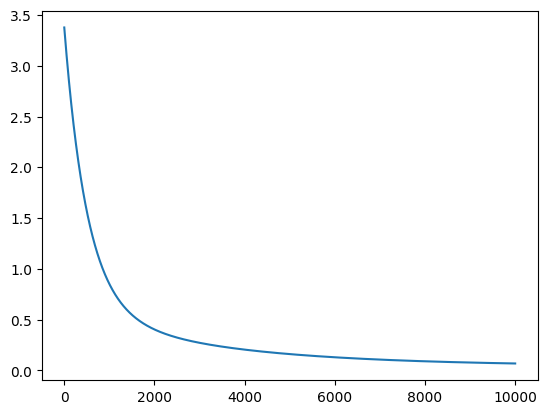

[[ 0.42303543]
 [-0.02708089]
 [ 0.15735087]
 [ 0.13300183]
 [-2.41800067]
 [-1.10314732]
 [-0.92938757]
 [-0.27581611]
 [ 0.53526236]
 [-0.14069923]
 [-0.23398697]
 [ 0.29959233]
 [-0.10884526]
 [-0.11041669]
 [ 0.91476894]
 [ 1.0825629 ]
 [ 1.06376411]
 [ 1.12771325]]
0.0354294184184146


In [36]:
import autograd.numpy as np_   # Thinly-wrapped version of Numpy
from autograd import grad

def loss( parametros ):
    w, b, pontos, real_value = parametros
    prediction = w.T @ pontos + b
    mse = np_.mean( (prediction - real_value)**2)
    return mse

g = grad(loss)

data = df_clean.drop(columns=["stroke"]).to_numpy().astype(float)

target = df_clean["stroke"].to_numpy().astype(float)

w = np.random.randn(data.shape[1],1)
b = 0.0
alpha = 10**-3
erros = []

for n in range(10000):
    grad_ = g( (w, b, data.T, target) )
    w -= alpha*grad_[0]
    b -= alpha*grad_[1]
    erros.append(loss( (w, b, data.T, target) ))

import matplotlib.pyplot as plt
plt.plot(erros)
plt.show()
    

print(w)
print(b)

# Modelo de classificação DecisionTreeClassifier

X são as feautures, que serão usadas para prever Y, que é o outcome ou target. 

Nesse caso, o target é a coluna stroke, que indica se o paciente teve ou não um AVC.
E as features são as outras colunas, que indicam as características do paciente.

Explicação célula 0:

Importância: 

from sklearn.tree import DecisionTreeClassifier: importa o modelo DecisionTreeClassifier, que é um modelo de classificação que será utilizado.

from sklearn.model_selection import train_test_split: importa a função train_test_split, que será utilizada para separar os dados em treino e teste.

Resultado:  Módulos necessários para o projeto importados .

célula 0

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split


Explicação célula 1:

Importância: Gerar as features. Para isso iremos remover a coluna stroke do nosso dataset, df_clean pois ela é o target, e não uma feature.

Resultado: DataFrame com as features

célula 1

In [37]:
# dataset 
# data, all columns except stroke
X = df_clean.drop(columns=["stroke"])
X

,hypertension,heart_disease,gender_Female,gender_Male,gender_Other,ever_married_No,ever_married_Yes,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
5,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5104,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0
5106,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
5107,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
5108,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [38]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split



# target, only stroke column
Y = df_clean["stroke"]

# split dataset into train and test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)


clf = DecisionTreeClassifier()

clf.fit(X_train, Y_train)

print(f"Accuracy: {clf.score(X_test, Y_test)}")

importance = []
for i in range(len(clf.feature_importances_)):
   importance.append((X.columns[i],clf.feature_importances_[i]))

importance.sort()
print( importance)


Accuracy: 0.9480651731160896
[('Residence_type_Rural', 0.02264206082758346), ('Residence_type_Urban', 0.07364694795324023), ('ever_married_No', 0.05326459166550142), ('ever_married_Yes', 0.024716646074961438), ('gender_Female', 0.09663468059860018), ('gender_Male', 0.05793152544483405), ('gender_Other', 0.0), ('heart_disease', 0.11437208338474053), ('hypertension', 0.1319823730437113), ('smoking_status_Unknown', 0.02800205203994908), ('smoking_status_formerly smoked', 0.06442568278177285), ('smoking_status_never smoked', 0.046573325090511215), ('smoking_status_smokes', 0.09965844052434257), ('work_type_Govt_job', 0.09550169685592977), ('work_type_Never_worked', 0.0), ('work_type_Private', 0.05162089514673846), ('work_type_Self-employed', 0.039007865194789174), ('work_type_children', 1.913337279429553e-05)]
